In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity
import pandas as pd

2023-09-09 00:11:02.525416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 00:11:03.201795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [5]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [6]:
data_folder = os.environ.get("DATA_DIR")

## load data

In [7]:
# Load vinicius data
path_v = f"{data_folder}/lhco/generated/FPCD_LHCO_SR.h5"
with h5py.File(path_v, "r") as f:
    print(f.keys())
    jet_features_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
    mjj_v = f["mjj"][:]
print(jet_features_v.shape)
print(particle_data_v.shape)
print(mjj_v.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(200000, 2, 5)
(200000, 2, 279, 3)
(200000,)


In [8]:
# Load idealized data
path_id = f"{data_folder}/lhco/generated/idealized_LHCO.h5"
with h5py.File(path_id, "r") as f:
    print(f.keys())
    jet_features_id = f["jet_features"][:]
    particle_data_id = f["particle_features"][:]
    mjj_id = f["mjj"][:]
print(jet_features_id.shape)
print(particle_data_id.shape)
print(mjj_id.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(121351, 2, 5)
(121351, 2, 279, 3)
(121351,)


In [9]:
# Load ced data
#path_ced = f"{data_folder}/lhco/generated/FM_LHCO_SR.h5"
#path_ced = f"{data_folder}/lhco/generated/lhco_both_jets-midpoint-250.h5"
#path_ced = f"{data_folder}/lhco/generated/latent64-midpoint-200.h5"
#path_ced = f"{data_folder}/lhco/generated/lhco-xy-midpoint-300.h5"
path_ced = f"{data_folder}/lhco/generated/lhco-xy-256-logpt_sr-midpoint-500.h5"
#path_ced = f"{data_folder}/lhco/generated/FPCD_LHCO_SR_2.h5"


with h5py.File(path_ced, "r") as f:
    print(f.keys())
    jet_features_ced = f["jet_features"][:]
    particle_data_ced = f["particle_features"][:]
    mjj_ced = f["mjj"][:]
    raw_ced = f["data_raw"][:]
print(jet_features_ced.shape)
print(particle_data_ced.shape)
#print(mjj_ced.shape)

<KeysViewHDF5 ['data_raw', 'jet_features', 'mjj', 'particle_features', 'particle_features_nonrel']>
(121351, 2, 5)
(121351, 2, 279, 3)


In [10]:
particle_data_v = particle_data_v[:len(particle_data_id)]
jet_features_v = jet_features_v[:len(jet_features_id)]
mjj_v = mjj_v[:len(mjj_id)]

In [11]:
particle_data_ced = particle_data_ced[...,[1,2,0]]
particle_data_id = particle_data_id[...,[1,2,0]]
particle_data_v = particle_data_v[...,[1,2,0]]

## calculate substructure

In [12]:
print(particle_data_ced.shape)
print(particle_data_id.shape)
print(particle_data_v.shape)

(121351, 2, 279, 3)
(121351, 2, 279, 3)
(121351, 2, 279, 3)


In [13]:
print(particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]).shape)

(242702, 279, 3)


In [14]:
#dump_hlvs(
#    particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]),
#    "/beegfs/desy/user/ewencedr/data/lhco/substructure/full_v",
#    plot=True,
#)

## Evaluate substructure

In [15]:
# load substructure for id data
data_substructure_id = []
keys = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/full_idealized" + ".h5", "r") as f:
    tau21_id = np.array(f["tau21"])
    tau32_id = np.array(f["tau32"])
    d2_id = np.array(f["d2"])
    for key in f.keys():
        keys.append(key)
        data_substructure_id.append(np.array(f[key]))
keys = np.array(keys)
data_substructure_id = np.array(data_substructure_id)

In [16]:
# load substructure for v data
data_substructure_v = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/full_vinicius" + ".h5", "r") as f:
    tau21_v = np.array(f["tau21"])
    tau32_v = np.array(f["tau32"])
    d2_v = np.array(f["d2"])
    for key in f.keys():
        data_substructure_v.append(np.array(f[key]))
data_substructure_v = np.array(data_substructure_v)

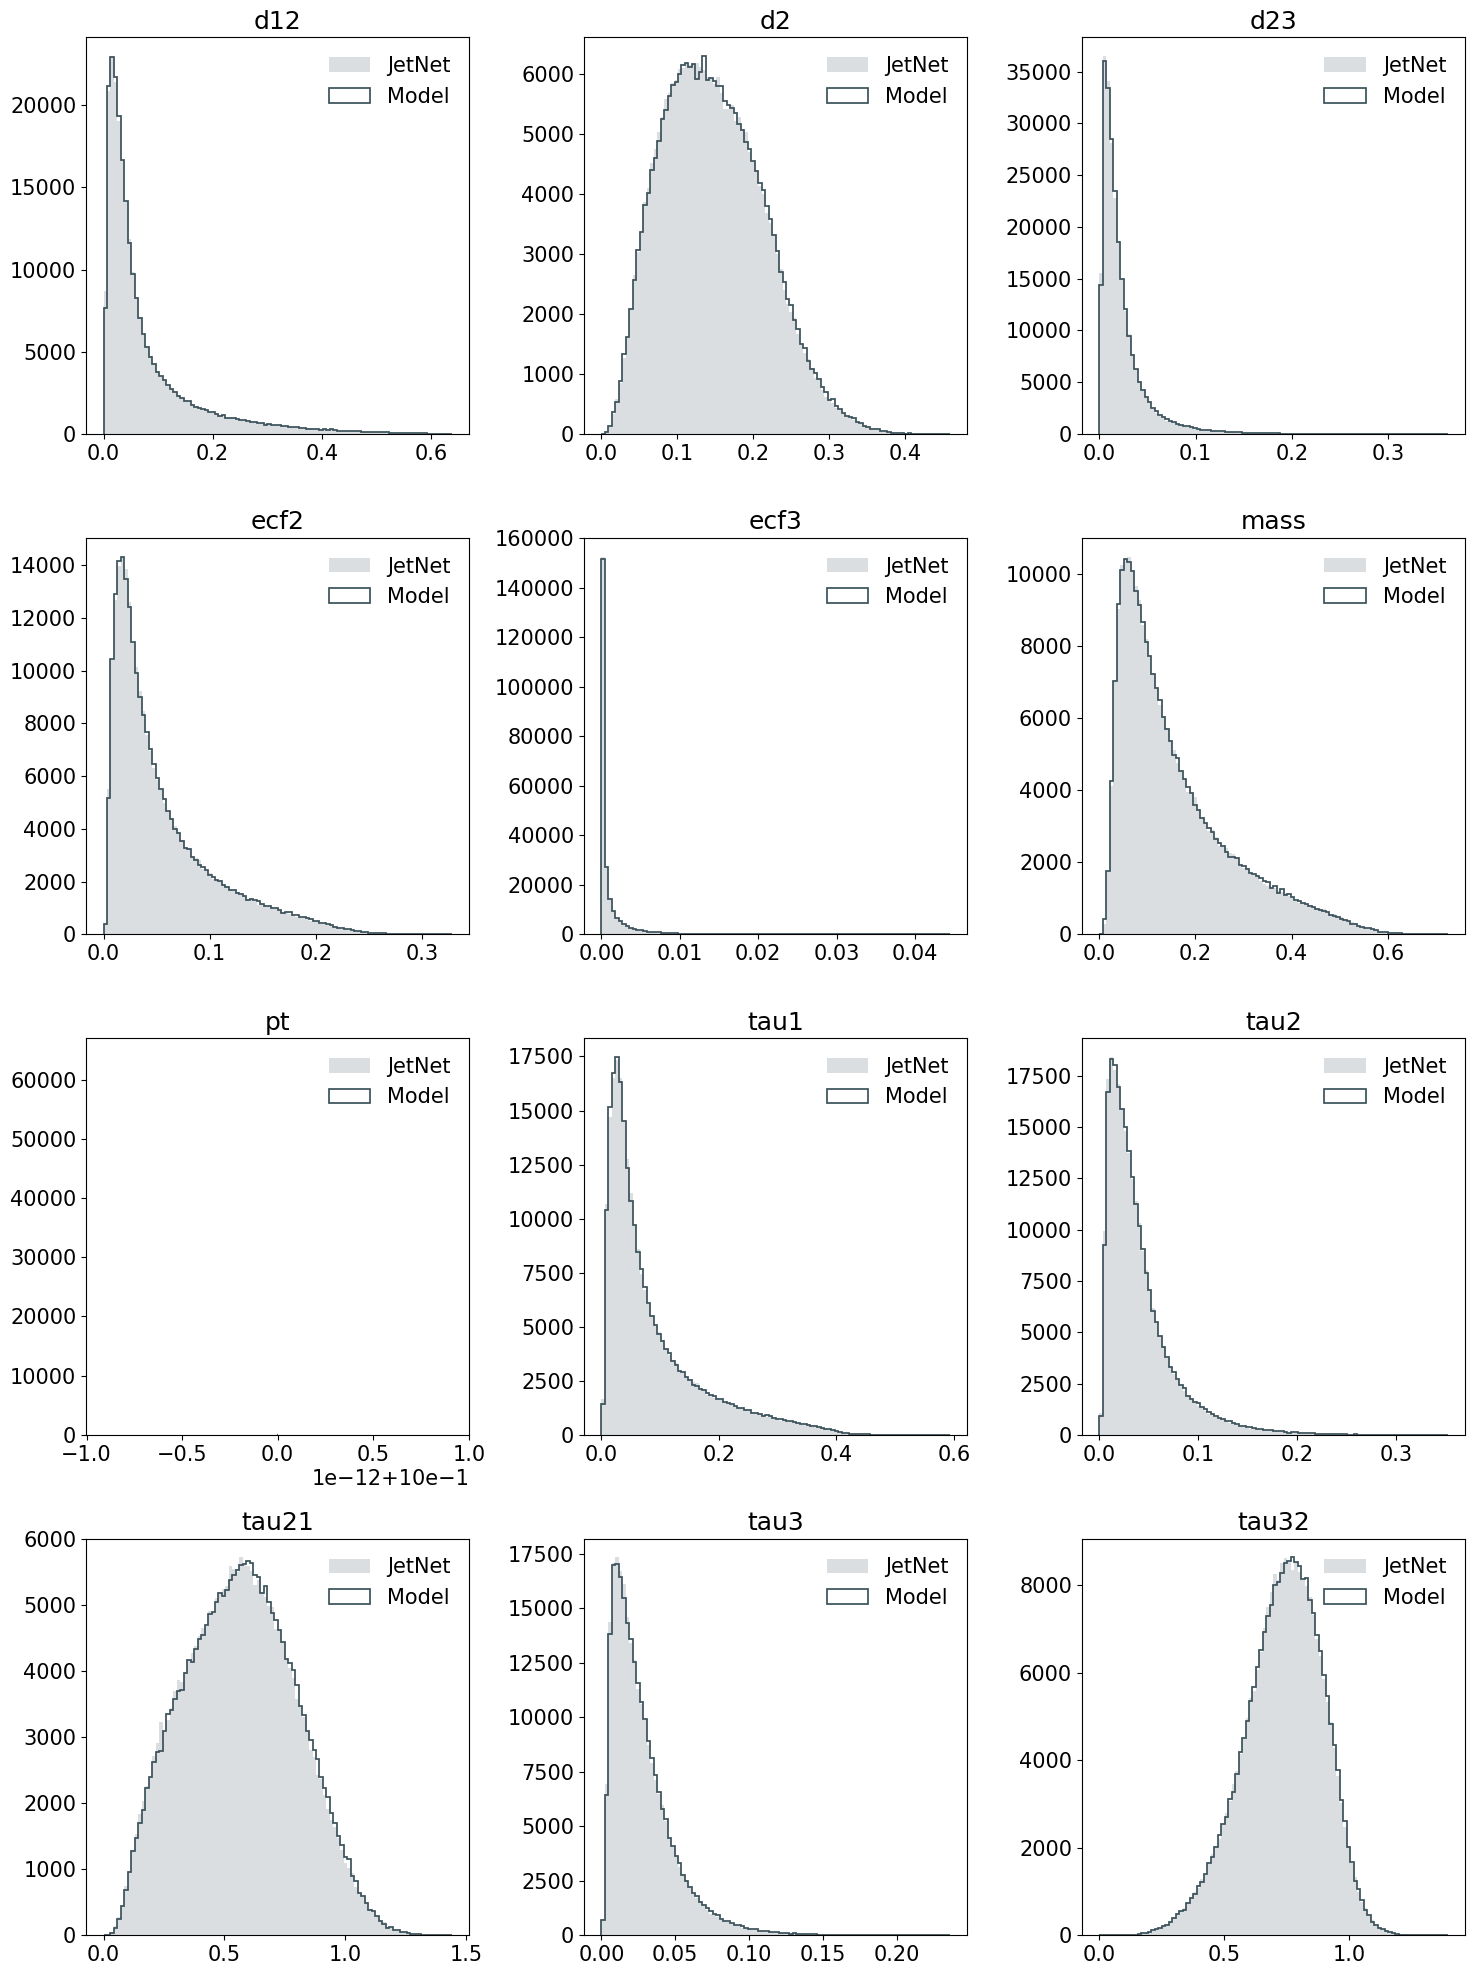

In [17]:
plot_full_substructure(
    data_substructure=data_substructure_v,
    data_substructure_jetnet=data_substructure_id,
    keys=keys,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

## bring data in cathode form

In [18]:
print(tau21_v.shape)
tau_21_v = tau21_v.reshape(-1, 2)
print(tau_21_v.shape)

(242702,)
(121351, 2)


In [54]:
def sort_jet_for_mass(particle_data, jet_features):
    
    jet_mass = jet_features[...,3]
    args = np.argsort(jet_mass, axis=-1)#[...,::-1]
    jet_features = np.take_along_axis(jet_features, args[..., None], axis=1)
    particle_data = np.take_along_axis(particle_data, args[..., None, None], axis=1)
    
    return particle_data, jet_features, args

In [64]:
def get_cathode_data(particle_data: np.array, jet_features: np.array, tau_21: np.array)->np.array:
    # sort jets by pt
    particle_data_sorted, jet_features_sorted, idcs = sort_jet_for_mass(particle_data, jet_features)
    tau_21_sorted = np.take_along_axis(tau_21, idcs, axis=1)
    # get features
    mj1 = jet_features_sorted[:,0,3]
    delta_mj = abs(jet_features_sorted[:,1,3] - jet_features_sorted[:,0,3])
    tau21j1 = tau_21_sorted[:,0]
    tau21j2 = tau_21_sorted[:,1]
    cathode_data = np.stack([mj1, delta_mj, tau21j2, tau21j1], axis=-1)
    return cathode_data

In [65]:
cathode_data_v = get_cathode_data(particle_data_v, jet_features_v, tau_21_v)

## compare to real data

In [22]:
path_features = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.features.h5"
df = pd.read_hdf(path_features)

In [111]:
print(df.keys())

Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label'],
      dtype='object')


In [113]:
background_features = df[df["label"] == 0]
print(background_features.shape)

(1000000, 15)


In [114]:
background_features = background_features[["mj1", "delta_mj", "tau21j1", "tau21j2"]].to_numpy()

KeyError: "['delta_mj', 'tau21j1', 'tau21j2'] not in index"

In [57]:
data_path_manuel = "/beegfs/desy/user/sommerhm/clean_notebook_cathode/input_data/"
innerdata_train = np.load(join(data_path_manuel, "innerdata_train.npy"))

In [58]:
print(innerdata_train)

[[3.3412125  0.0852339  0.0443031  0.5626404  0.70104648 0.        ]
 [3.57722075 0.0851619  0.1021171  0.2555552  0.3022931  0.        ]
 [3.65779859 0.127804   0.353015   0.93686371 0.24703147 0.        ]
 ...
 [3.42941068 0.0752109  0.0411651  0.69934458 0.52281424 0.        ]
 [3.47150979 0.194183   0.20524699 0.82260282 0.34609451 0.        ]
 [3.39644824 0.11087    0.053731   0.52371193 0.49841597 0.        ]]


In [66]:
data_manuel = innerdata_train[:,1:5]
data_manuel[:,0] = data_manuel[:,0].copy() * 1000
data_manuel[:,1] = data_manuel[:,1].copy() * 1000
print(data_manuel.shape)

(61375, 4)


In [67]:
print(data_manuel.shape)
print(cathode_data_v.shape)
cathode_data_v_plot = cathode_data_v[:len(data_manuel)]

(61375, 4)
(121351, 4)


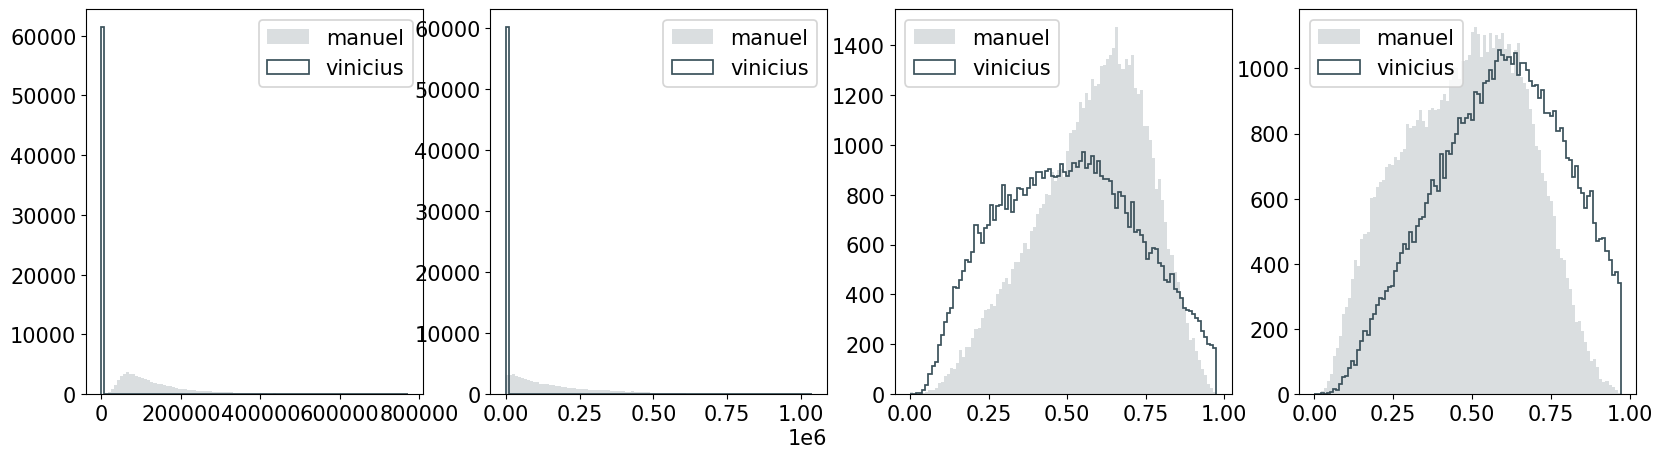

In [68]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs.flatten()):
    hist = ax.hist(data_manuel[:, i], bins=100, alpha=0.5, label="manuel")
    ax.hist(cathode_data_v_plot[:, i], bins=hist[1], label="vinicius", histtype="step")
    ax.legend()
plt.show()

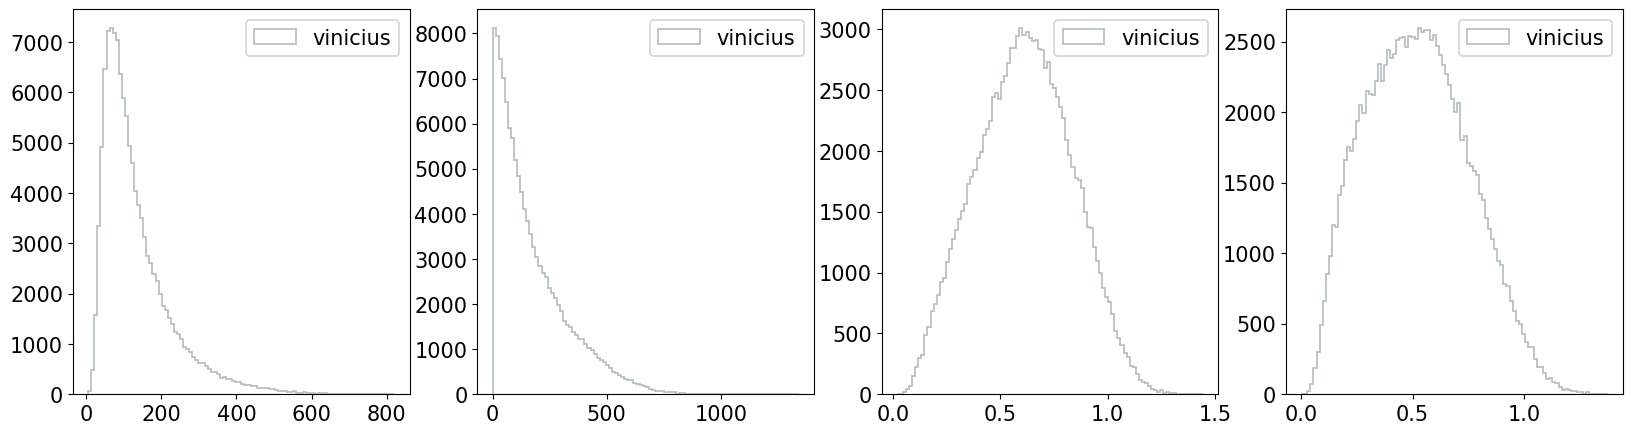

In [62]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs.flatten()):
    #hist = ax.hist(innerdata_train[:, i], bins=100, alpha=0.5, label="manuel")
    ax.hist(cathode_data_v[:, i], bins=100, label="vinicius", histtype="step")
    ax.legend()
plt.show()